# Image classification example using a CNN with Tensorflow

This example is taken to a good amount from [github.com/GzuPark/image_classification](https://github.com/GzuPark/image_classification/blob/master/dlnd_image_classification.ipynb) with some minor code changes and some model architecture changes to improve the total accuracy.

We use images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) in this example. These are images from airplanes, dogs, cats, ships, deers etc.

The dataset is in the `cifar-10-batches-py` folder.

In [1]:
cifar10_dir= 'cifar-10-batches-py'


The dataset has 5 batches, with each batch having labels and images from one of the 10 classes:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

In [2]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## Exploring the data

Let's have a look in the data...

In [3]:
# Setting up the environment
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle


In [4]:
# Function to load a batch into memory
def load_batch(data_dir, batch_id):
    with open(os.path.join(cifar10_dir, 'data_batch_%i' % batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')
    feats = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    lbls = batch['labels']
    return feats, lbls

In [5]:
# and load the first batch
feats, labels = load_batch(cifar10_dir, 1)

Label Id: 3 - Class: cat


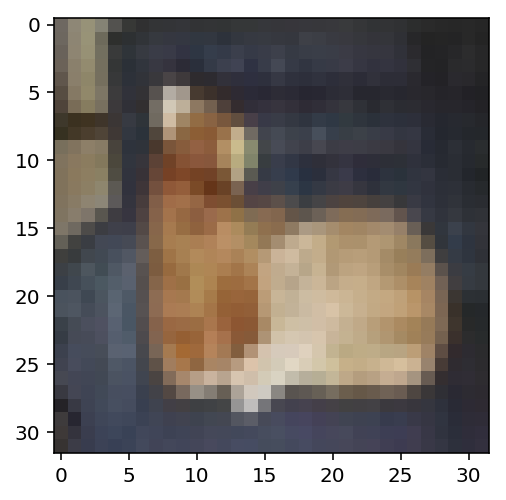

In [6]:
sample_id = 17
sample_img = feats[sample_id]
sample_lbl = labels[sample_id]
print('Label Id: {} - Class: {}'.format(sample_lbl, label_names[sample_lbl]))
plt.imshow(sample_img)

In [7]:
# some stats
print([sample_img.min(), sample_img.max(), sample_img.shape])

[25, 225, (32, 32, 3)]


## Preprocessing

### Normalizing the data

We need to preprocess the data which is scaled between 0 and 255 to be within 0 and 1.

In [8]:
def normalize(x):
    return x / 255.

### One-hot encoding

Instead of having 1 column with the 10 class labels, we need to have a vector of 10 numbers of 0 or 1. For each image, only one item of the vector is of course 1, all others are 0. This is this kind of data we will predict. In fact, we will rather predict the probability for each of the classes and pick the maximum as our resulting class.

In [9]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer().fit(range(10))

def one_hot_encode(x):
    global lb
    return lb.transform(x)

### Split into training and test data

We take out 10% of the data of each batch and save it to a test dataset. At the same time, we normalize and one-hot encode everything.

In [10]:
test_feats, test_lbls = [], []

In [11]:
for i in range(1, 6):
    feats, lbls = load_batch(cifar10_dir, i)
    test_size = int(len(feats) * 0.1)
    
    # training data
    norm_feats = normalize(feats[:-test_size])
    one_hot_lbls = one_hot_encode(lbls[:-test_size])
    pickle.dump((norm_feats, one_hot_lbls), open('preprocess_batch_%i.p' % i, 'wb'))
    
    # add the rest to the test data
    test_feats.extend(feats[-test_size:])
    test_lbls.extend(lbls[-test_size:])

# dump the test data too
norm_test_feats = normalize(np.array(test_feats))
one_hot_test_lbls = one_hot_encode(np.array(test_lbls))
pickle.dump((norm_test_feats, one_hot_test_lbls), open('preprocess_test.p', 'wb'))


## Build the network

In [12]:
import tensorflow as tf

In [13]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # Weights
    W_shape = list(conv_ksize) + [int(x_tensor.shape[3]), conv_num_outputs]
    W = tf.Variable(tf.truncated_normal(W_shape, stddev=.05))
    
    # Apply convolution
    x = tf.nn.conv2d(
        x_tensor, W,
        strides = [1] + list(conv_strides) + [1],
        padding = 'SAME'
    )
    
    # Add bias
    b = tf.Variable(tf.zeros([conv_num_outputs]))
    x = tf.nn.bias_add(x, b)
    
    # Nonlinear activation (ReLU)
    x = tf.nn.relu(x)
    
    # Max pooling
    return tf.nn.max_pool(
        x,
        ksize = [1] + list(pool_ksize) + [1],
        strides = [1] + list(pool_strides) + [1],
        padding = 'SAME'
    )

In [14]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape.as_list()[1:])])

In [15]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The fully connected layer
    x = tf.add(tf.matmul(x_tensor, W), b)
    
    # ReLU activation function
    return tf.nn.relu(x)

In [16]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # Weights and bias
    W = tf.Variable(tf.truncated_normal([int(x_tensor.shape[1]), num_outputs], stddev=.05))
    b = tf.Variable(tf.zeros([num_outputs]))
    
    # The output layer
    return tf.add(tf.matmul(x_tensor, W), b)

In [17]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # 3 convolution layers with max pooling
    # All layers with same kernel, stride and maxpooling params
    x = conv2d_maxpool(x, 64, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
    x = conv2d_maxpool(x, 256, (3,3), (1,1), (2,2), (2,2))
    
    # dropout after convolutions
    x = tf.nn.dropout(x, keep_prob)
    
    # flatten layer
    x = flatten(x)

    # 1 fully connected layer followed by dropout
    x = fully_conn(x, 1024)
    x = tf.nn.dropout(x, keep_prob)
    
    # output layer
    return output(x, 10)


Finally build the network itself:

In [18]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = tf.placeholder(tf.float32, [None, 32, 32, 3], name="x")
y = tf.placeholder(tf.float32, [None, 10], name="y")
keep_prob = tf.placeholder(tf.float32, name="keep_prob")

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


Prepare a function that yields loss and validation accuracy during training and validation:

In [19]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    global valid_features, valid_labels
    loss = sess.run(cost, feed_dict={x: feature_batch, y: label_batch, keep_prob: 1.})
    valid_acc = sess.run(
        accuracy, 
        feed_dict={
            x: norm_test_feats,
            y: one_hot_test_lbls,
            keep_prob: 1.
        }
    )
    print('Loss: {:>8.4f}, Validation Accuracy: {:>8.6f}'.format(loss, valid_acc))

Define the hyperparameters for the model:

In [20]:
epochs = 80
batch_size = 1024
keep_probability = 0.5


Functions for loading the preprocessed training data:

In [21]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)

**Train the model**:

In [22]:
print("Training...")
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        n_batches = 5
        for batch_i in range(1, n_batches+1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                sess.run(
                    optimizer, 
                    feed_dict={
                        x: batch_features, 
                        y: batch_labels, 
                        keep_prob: keep_probability
                    }
                )
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
    
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, './image_classification')

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:   2.1154, Validation Accuracy: 0.251600
Epoch  1, CIFAR-10 Batch 2:  Loss:   1.8830, Validation Accuracy: 0.340400
Epoch  1, CIFAR-10 Batch 3:  Loss:   1.7558, Validation Accuracy: 0.349200
Epoch  1, CIFAR-10 Batch 4:  Loss:   1.6675, Validation Accuracy: 0.399200
Epoch  1, CIFAR-10 Batch 5:  Loss:   1.5634, Validation Accuracy: 0.428600
Epoch  2, CIFAR-10 Batch 1:  Loss:   1.4796, Validation Accuracy: 0.467400
Epoch  2, CIFAR-10 Batch 2:  Loss:   1.4239, Validation Accuracy: 0.476800
Epoch  2, CIFAR-10 Batch 3:  Loss:   1.3235, Validation Accuracy: 0.505000
Epoch  2, CIFAR-10 Batch 4:  Loss:   1.2974, Validation Accuracy: 0.522800
Epoch  2, CIFAR-10 Batch 5:  Loss:   1.2653, Validation Accuracy: 0.533800
Epoch  3, CIFAR-10 Batch 1:  Loss:   1.2227, Validation Accuracy: 0.543800
Epoch  3, CIFAR-10 Batch 2:  Loss:   1.2210, Validation Accuracy: 0.563400
Epoch  3, CIFAR-10 Batch 3:  Loss:   1.1541, Validation Accuracy: 0.564200
Epoch  3, CIF

Epoch 22, CIFAR-10 Batch 5:  Loss:   0.2046, Validation Accuracy: 0.796600
Epoch 23, CIFAR-10 Batch 1:  Loss:   0.2563, Validation Accuracy: 0.795000
Epoch 23, CIFAR-10 Batch 2:  Loss:   0.2377, Validation Accuracy: 0.790600
Epoch 23, CIFAR-10 Batch 3:  Loss:   0.2319, Validation Accuracy: 0.797800
Epoch 23, CIFAR-10 Batch 4:  Loss:   0.2329, Validation Accuracy: 0.792400
Epoch 23, CIFAR-10 Batch 5:  Loss:   0.1942, Validation Accuracy: 0.794200
Epoch 24, CIFAR-10 Batch 1:  Loss:   0.2496, Validation Accuracy: 0.791200
Epoch 24, CIFAR-10 Batch 2:  Loss:   0.2379, Validation Accuracy: 0.802000
Epoch 24, CIFAR-10 Batch 3:  Loss:   0.2293, Validation Accuracy: 0.792600
Epoch 24, CIFAR-10 Batch 4:  Loss:   0.1977, Validation Accuracy: 0.795200
Epoch 24, CIFAR-10 Batch 5:  Loss:   0.1786, Validation Accuracy: 0.790600
Epoch 25, CIFAR-10 Batch 1:  Loss:   0.2250, Validation Accuracy: 0.789600
Epoch 25, CIFAR-10 Batch 2:  Loss:   0.2188, Validation Accuracy: 0.798200
Epoch 25, CIFAR-10 Batch 

Epoch 44, CIFAR-10 Batch 4:  Loss:   0.0472, Validation Accuracy: 0.804600
Epoch 44, CIFAR-10 Batch 5:  Loss:   0.0416, Validation Accuracy: 0.804600
Epoch 45, CIFAR-10 Batch 1:  Loss:   0.0411, Validation Accuracy: 0.809800
Epoch 45, CIFAR-10 Batch 2:  Loss:   0.0425, Validation Accuracy: 0.808800
Epoch 45, CIFAR-10 Batch 3:  Loss:   0.0570, Validation Accuracy: 0.802000
Epoch 45, CIFAR-10 Batch 4:  Loss:   0.0302, Validation Accuracy: 0.816000
Epoch 45, CIFAR-10 Batch 5:  Loss:   0.0313, Validation Accuracy: 0.812600
Epoch 46, CIFAR-10 Batch 1:  Loss:   0.0370, Validation Accuracy: 0.815800
Epoch 46, CIFAR-10 Batch 2:  Loss:   0.0260, Validation Accuracy: 0.821000
Epoch 46, CIFAR-10 Batch 3:  Loss:   0.0369, Validation Accuracy: 0.818400
Epoch 46, CIFAR-10 Batch 4:  Loss:   0.0311, Validation Accuracy: 0.812400
Epoch 46, CIFAR-10 Batch 5:  Loss:   0.0289, Validation Accuracy: 0.818400
Epoch 47, CIFAR-10 Batch 1:  Loss:   0.0295, Validation Accuracy: 0.814400
Epoch 47, CIFAR-10 Batch 

Epoch 66, CIFAR-10 Batch 3:  Loss:   0.0089, Validation Accuracy: 0.816800
Epoch 66, CIFAR-10 Batch 4:  Loss:   0.0073, Validation Accuracy: 0.819200
Epoch 66, CIFAR-10 Batch 5:  Loss:   0.0090, Validation Accuracy: 0.818200
Epoch 67, CIFAR-10 Batch 1:  Loss:   0.0094, Validation Accuracy: 0.811400
Epoch 67, CIFAR-10 Batch 2:  Loss:   0.0090, Validation Accuracy: 0.809000
Epoch 67, CIFAR-10 Batch 3:  Loss:   0.0109, Validation Accuracy: 0.815000
Epoch 67, CIFAR-10 Batch 4:  Loss:   0.0090, Validation Accuracy: 0.813800
Epoch 67, CIFAR-10 Batch 5:  Loss:   0.0090, Validation Accuracy: 0.819000
Epoch 68, CIFAR-10 Batch 1:  Loss:   0.0075, Validation Accuracy: 0.812800
Epoch 68, CIFAR-10 Batch 2:  Loss:   0.0075, Validation Accuracy: 0.818800
Epoch 68, CIFAR-10 Batch 3:  Loss:   0.0099, Validation Accuracy: 0.812400
Epoch 68, CIFAR-10 Batch 4:  Loss:   0.0087, Validation Accuracy: 0.812800
Epoch 68, CIFAR-10 Batch 5:  Loss:   0.0094, Validation Accuracy: 0.815600
Epoch 69, CIFAR-10 Batch 

**Test the model**

We test the model against the test dataset to assess the model accuracy.

_Checkpoint_: once we have trained our model, we can start here without running everything again.

In [23]:
import tensorflow as tf
import pickle
import random
import numpy as np

In [24]:
model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

In [25]:
test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
loaded_graph = tf.Graph()


In [26]:
def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [33]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.8151358485221862



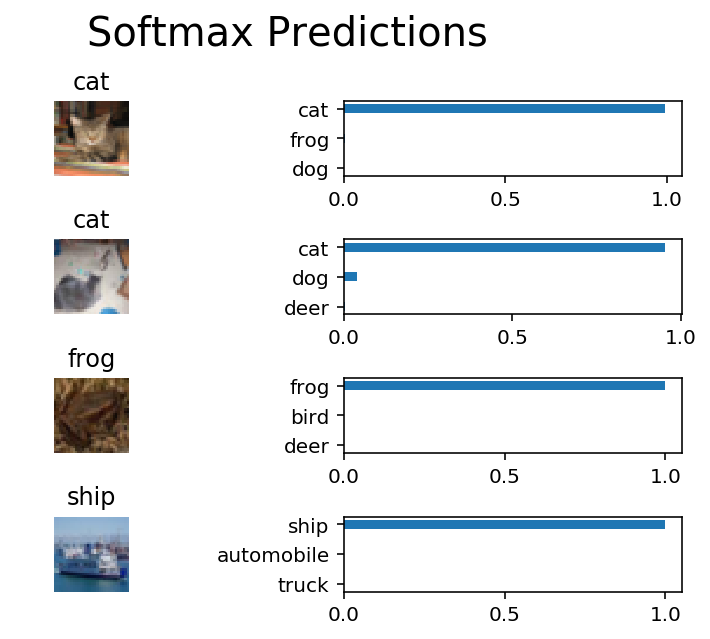

In [34]:
with tf.Session(graph=loaded_graph) as sess:
    # Load model
    loader = tf.train.import_meta_graph(model_path + '.meta')
    loader.restore(sess, model_path)

    # Get Tensors from loaded model
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
    loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
    # Get accuracy in batches for memory limitations
    test_batch_acc_total = 0
    test_batch_count = 0
    
    for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
        test_batch_acc_total += sess.run(
            loaded_acc,
            feed_dict={
                loaded_x: test_feature_batch, 
                loaded_y: test_label_batch, 
                loaded_keep_prob: 1.0
            }
        )
        test_batch_count += 1

    print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

    # Print Random Samples
    random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
    random_test_predictions = sess.run(
        tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
        feed_dict={
            loaded_x: random_test_features, 
            loaded_y: random_test_labels, 
            loaded_keep_prob: 1.0
        }
    )
    display_image_predictions(random_test_features, random_test_labels, random_test_predictions)
